In [103]:
import os
import h3
import json
import random
import numpy as np
import pandas as pd
import dask.dataframe as dd
import folium
from geojson import Feature, Point, FeatureCollection
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
## from https://jens-wirelesscar.medium.com/lhexagone-in-hexagons-uber-h3-map-1566bc412172
## weak revised

def hexagons_dataframe_to_geojson(df_hex, file_output=None, column_name="value", hex_id_column_name="polygon6_id"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        try:
            geometry_for_row = {
                "type" : "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(h=row[hex_id_column_name], geo_json=True)]
            }
            feature = Feature(
                geometry=geometry_for_row ,
                id=row[hex_id_column_name],
                properties={column_name : row[column_name]}
            )
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row[hex_id_column_name]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result


def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))


def choropleth_map(
        df, column_name="value", border_color="black", fill_opacity=0.7, color_map_name="Blues", initial_map=None
    ):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    # colormap
    min_value = df[column_name].min()
    max_value = df[column_name].max()
    mean_value = df[column_name].mean()
    
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df)
    
    if initial_map is None:
        initial_map = folium.Map(
            location=[55.7522200, 37.6155600],
            zoom_start=9,
        )

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(
        df,
        column_name=column_name
    )

    # color_map_name 'Blues' for now, many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity
        }, 
        name=name_layer,
        tooltip=folium.GeoJsonTooltip([column_name])
    ).add_to(initial_map)
    

    return initial_map

In [3]:
AGGREGATES_DATA_PATH = "../data/aggregates/2021_15min_bme280"

In [9]:
# small data, could process with pandas
df = dd.read_parquet(AGGREGATES_DATA_PATH).compute()

In [10]:
df.head()

timestamp      polygon6_id      pressure  temperature   humidity
0 2021-12-01  861181a67ffffff  96623.852273    -2.285454  87.501820
1 2021-12-01  861181b07ffffff  96458.135417     2.233333  63.456665
2 2021-12-01  861181b47ffffff  96220.260417    -1.906667  80.309998
3 2021-12-01  861181b4fffffff  96026.979167    -2.166667  72.436666
4 2021-12-01  861181b5fffffff  96567.402778    -3.831111  91.244446

Get sample for plotting (from random timestamp)

In [34]:
df_sample = df[df["timestamp"] == random.choice(df["timestamp"].unique())]

df_sample.head()

timestamp      polygon6_id       pressure  temperature  \
61042 2021-12-12 08:45:00  861181a67ffffff  101345.875000    -7.842143   
61043 2021-12-12 08:45:00  861181b07ffffff  101034.531250    -2.751667   
61044 2021-12-12 08:45:00  861181b47ffffff  100843.812500    -7.690000   
61045 2021-12-12 08:45:00  861181b4fffffff  100664.458333    -6.961667   
61046 2021-12-12 08:45:00  861181b5fffffff  101244.736111    -9.457778   

        humidity  
61042  70.118574  
61043  55.128337  
61044  78.688334  
61045  62.931666  
61046  85.306112

In [63]:
color = "Reds"
feature = "temperature"

m = choropleth_map(
    df=df_sample.round(2),
    column_name=feature,
    color_map_name=color
)
print(feature)
m

temperature


In [58]:
color = "Blues"
feature = "humidity"

m = choropleth_map(
    df=df_sample,
    column_name=feature,
    color_map_name=color
)
print(feature)
m

humidity


In [62]:
color = "Greens"
feature = "pressure"

m = choropleth_map(
    df=df_sample.round(2),
    column_name=feature,
    color_map_name=color
)
print(feature)
m

pressure


Short EDA

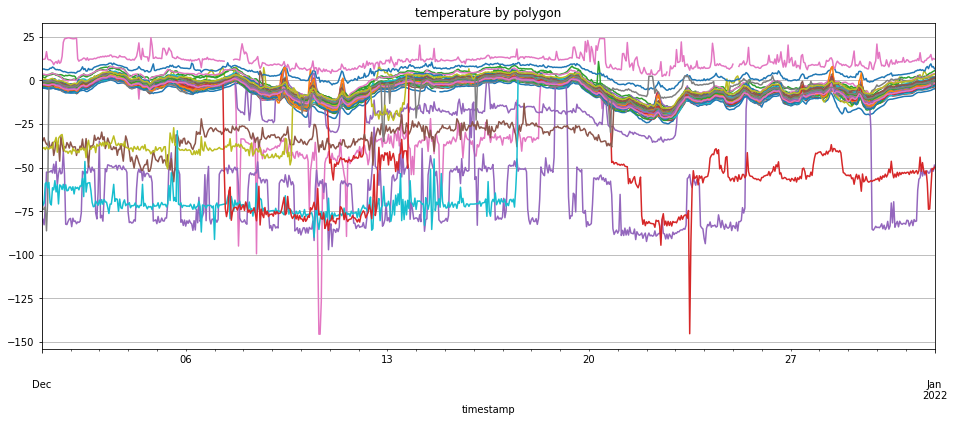

In [125]:
df\
.set_index("timestamp")\
.groupby([pd.Grouper(freq="1H"), "polygon6_id"]).mean().unstack()\
["temperature"].plot(legend=False, figsize=[16, 6], title="temperature by polygon").grid();

count    59.000000
mean      7.588321
std       6.198393
min       1.304985
25%       5.395156
50%       5.630710
75%       5.941817
80%       6.017887
90%      13.986091
95%      26.276945
max      32.460316
Name: temperature, dtype: float64


e:\polygon\projects\breathe\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='temperature', ylabel='Density'>

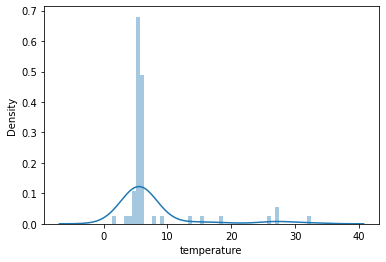

In [101]:
# drop polygon6_id's with anomalies
std = df\
.set_index("timestamp")\
.groupby([pd.Grouper(freq="1H"), "polygon6_id"])\
["temperature"].mean().reset_index().groupby("polygon6_id")["temperature"].std().sort_values(ascending=False)

print(std.describe(percentiles=[0.25, 0.50, 0.75, 0.8, 0.90, 0.95]))
sns.distplot(std)

In [131]:
df_filtered = df[df["polygon6_id"].isin(std[std<np.percentile(std, 80)].index)]

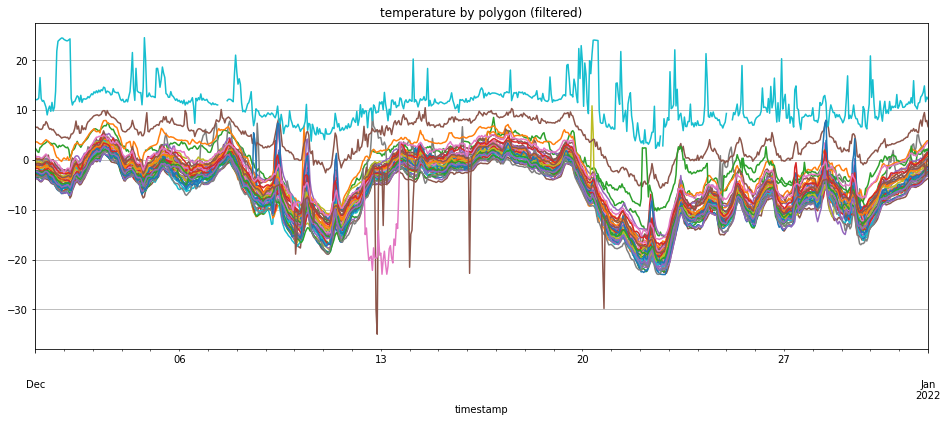

In [132]:
df_filtered\
.set_index("timestamp")\
.groupby([pd.Grouper(freq="1H"), "polygon6_id"]).mean().unstack()\
["temperature"].plot(legend=False, figsize=[16, 6], title="temperature by polygon (filtered)").grid();

Plot with no anomalies

In [133]:
df_sample = df_filtered[df_filtered["timestamp"] == random.choice(df_filtered["timestamp"].unique())]

df_sample.head()

timestamp      polygon6_id       pressure  temperature  \
53738 2021-12-11 00:45:00  861181a67ffffff  101557.326389   -16.037777   
53739 2021-12-11 00:45:00  861181b07ffffff  101179.885417   -10.865000   
53740 2021-12-11 00:45:00  861181b47ffffff  100976.843750   -14.443334   
53741 2021-12-11 00:45:00  861181b4fffffff  100791.812500   -10.551667   
53742 2021-12-11 00:45:00  861181b5fffffff  101374.610294   -18.128824   

        humidity  
53738  65.044447  
53739  47.480001  
53740  67.289998  
53741  46.568334  
53742  79.287059

In [134]:
color = "Reds"
feature = "temperature"

m = choropleth_map(
    df=df_sample.round(2),
    column_name=feature,
    color_map_name=color
)
print(feature)
m

temperature


In [135]:
color = "Blues"
feature = "humidity"

m = choropleth_map(
    df=df_sample,
    column_name=feature,
    color_map_name=color
)
print(feature)
m

humidity


In [136]:
color = "Greens"
feature = "pressure"

m = choropleth_map(
    df=df_sample.round(2),
    column_name=feature,
    color_map_name=color
)
print(feature)
m

pressure


In [137]:
m.save("../map.html")